100%|██████████████████████████████████████████████████████████████████████████████| 1256/1256 [03:19<00:00,  6.28it/s]


Epochs: 1
               Train Loss:  0.754
               Train Accuracy:  0.445
               Val Loss:  0.611
               Val Accuracy:  0.586


100%|██████████████████████████████████████████████████████████████████████████████| 1256/1256 [03:29<00:00,  6.00it/s]


Epochs: 2
               Train Loss:  0.473
               Train Accuracy:  0.684
               Val Loss:  0.471
               Val Accuracy:  0.694


100%|██████████████████████████████████████████████████████████████████████████████| 1256/1256 [03:33<00:00,  5.89it/s]


Epochs: 3
               Train Loss:  0.287
               Train Accuracy:  0.826
               Val Loss:  0.415
               Val Accuracy:  0.729


100%|██████████████████████████████████████████████████████████████████████████████| 1256/1256 [03:32<00:00,  5.91it/s]


Epochs: 4
               Train Loss:  0.200
               Train Accuracy:  0.878
               Val Loss:  0.469
               Val Accuracy:  0.726


100%|██████████████████████████████████████████████████████████████████████████████| 1256/1256 [03:30<00:00,  5.97it/s]


Epochs: 5
               Train Loss:  0.157
               Train Accuracy:  0.906
               Val Loss:  0.447
               Val Accuracy:  0.736


100%|██████████████████████████████████████████████████████████████████████████████| 1256/1256 [03:29<00:00,  6.01it/s]


Epochs: 6
               Train Loss:  0.131
               Train Accuracy:  0.915
               Val Loss:  0.448
               Val Accuracy:  0.742


100%|██████████████████████████████████████████████████████████████████████████████| 1256/1256 [03:28<00:00,  6.02it/s]


Epochs: 7
               Train Loss:  0.115
               Train Accuracy:  0.920
               Val Loss:  0.422
               Val Accuracy:  0.726


100%|██████████████████████████████████████████████████████████████████████████████| 1256/1256 [03:28<00:00,  6.03it/s]


Epochs: 8
               Train Loss:  0.105
               Train Accuracy:  0.928
               Val Loss:  0.459
               Val Accuracy:  0.745


100%|██████████████████████████████████████████████████████████████████████████████| 1256/1256 [03:28<00:00,  6.03it/s]


Epochs: 9
               Train Loss:  0.097
               Train Accuracy:  0.930
               Val Loss:  0.469
               Val Accuracy:  0.742


100%|██████████████████████████████████████████████████████████████████████████████| 1256/1256 [03:28<00:00,  6.03it/s]


Epochs: 10
               Train Loss:  0.092
               Train Accuracy:  0.935
               Val Loss:  0.464
               Val Accuracy:  0.745
Test Accuracy:  0.721
Recall for label 0: 64.71%
Precision for label 0: 61.80%
F1 for label 0: 63.22
Recall for label 1: 72.28%
Precision for label 1: 69.52%
F1 for label 1: 70.87
Recall for label 2: 60.00%
Precision for label 2: 80.00%
F1 for label 2: 68.57
Recall for label 3: 89.47%
Precision for label 3: 73.91%
F1 for label 3: 80.95
Recall for label 4: 94.12%
Precision for label 4: 100.00%
F1 for label 4: 96.97
Recall for label 5: 58.33%
Precision for label 5: 63.64%
F1 for label 5: 60.87
Recall for label 6: 100.00%
Precision for label 6: 100.00%
F1 for label 6: 100.00
Recall for label 7: 40.00%
Precision for label 7: 72.73%
F1 for label 7: 51.61


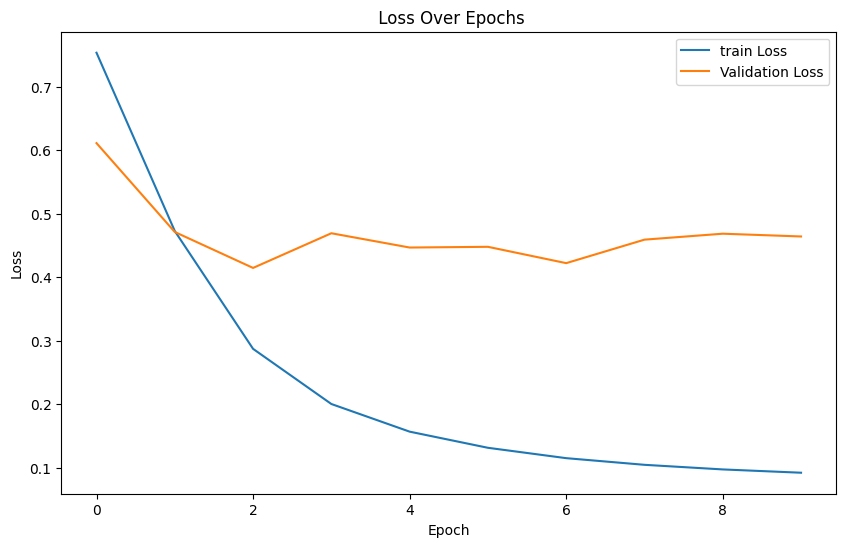

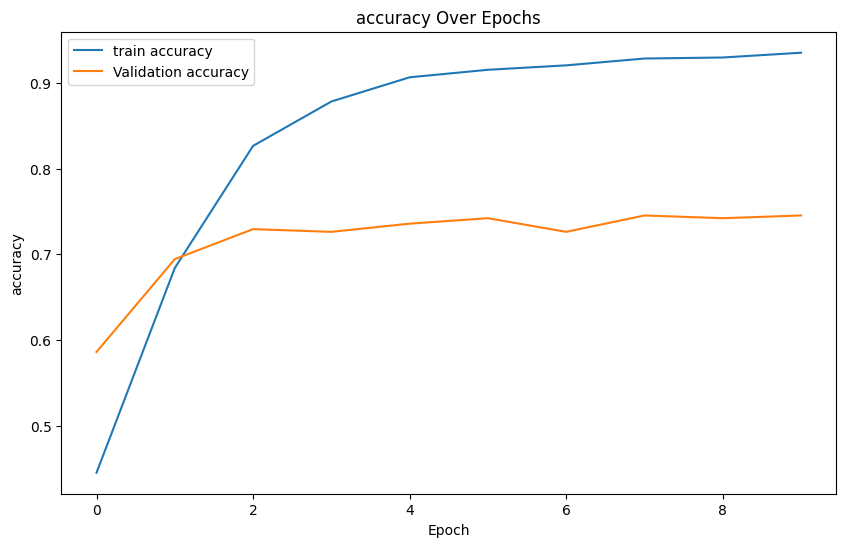

In [1]:
import torch
import numpy as np
from transformers import BertTokenizer,BertModel
import pandas as pd
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

"""
this method is used Bert to classifies all user stories into 8 labels (include the functional and non-functional user stories)
"""

#dataload
df = pd.read_csv('dataset/user_stories_data.csv')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'Usability':0,
          'Functional':1,
          'Maintainability':2,
          'Security':3,
          'Portability':4,
          'Performance':5,
          'Compatibility':6,
          'Reliability':7
          }



#dataset
class Dataset(Dataset):
    def __init__(self,df):
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length = 512,
                                truncation=True,
                                return_tensors="pt")
                      for text in df['texts']]
        self.labels = [labels[label] for label in df['labels']]


    def __len__(self):
        return len(self.labels)


    def __getitem__(self, idx):
        text = self.texts[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return text,label


# classifier
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 8)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)
        return final_layer



# train
def train(model,train_data,val_data,learning_rate,epochs):

    train,val = Dataset(train_data),Dataset(val_data)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(),lr = learning_rate)
    schedular = ExponentialLR(optimizer,gamma=0.7)
    model = model.to(device)
    criterion = criterion.to(device)
    for epoch in range(epochs):
        total_acc_train = 0
        total_loss_train = 0

        for train_input,train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask)
            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc
            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():
            for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            train_acc.append(total_acc_train / len(train_data))
            val_acc.append(total_acc_val / len(val_data))
            train_loss.append(total_loss_train / len(train_data))
            val_loss.append(total_loss_val / len(val_data))
            print(
                f'''Epochs: {epoch + 1}
               Train Loss: {total_loss_train / len(train_data): .3f}
               Train Accuracy: {total_acc_train / len(train_data): .3f}
               Val Loss: {total_loss_val / len(val_data): .3f}
               Val Accuracy: {total_acc_val / len(val_data): .3f}''')
        schedular.step()

#evaluate
def evaluate(model, test_data):

    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if use_cuda:
        model = model.cuda()

    model.eval()
    correct_pred = {label:0 for label in labels.values()}
    total_label = {label:0 for label in labels.values()}
    total_pred = {label:0 for label in labels.values()}
    total_acc_test = 0

    with torch.no_grad():
        for test_input, test_label in test_dataloader:
              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)
              output = model(input_id, mask)
              preds = output.argmax(dim=1)
              for label,pred in zip(test_label,preds):
                  total_label[label.item()] += 1 # total sample of this label is counted
                  total_pred[pred.item()] +=1 # total predcit labels
                  if label == pred:
                      correct_pred[label.item()] += 1 # True positive
              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

    for label, correct_count in correct_pred.items():
        recall = 100 * correct_count / total_label[label] if total_label[label] > 0 else 0
        print(f'Recall for label {label}: {recall:.2f}%')
        precision = 100 * correct_count / total_pred[label] if total_pred[label] > 0 else 0
        print(f'Precision for label {label}: {precision:.2f}%')
        if precision + recall > 0:
            F1_score = 2 * (precision * recall)/(precision + recall)
        else:
            F1_score = 0
        print(f'F1 for label {label}: {F1_score:.2f}')



# main
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),
                                     [int(.8*len(df)), int(.9*len(df))])
EPOCHS = 10
model = BertClassifier()
LR = 5e-6
train_loss=[]
val_loss=[]
train_acc=[]
val_acc=[]
train(model, df_train, df_val, LR, EPOCHS)
evaluate(model, df_test)



#plot
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(' Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('accuracy Over Epochs')
plt.legend()
plt.show()
model_path = './bert_classifier.pth'  # Save to the current directory
torch.save(model.state_dict(), model_path)

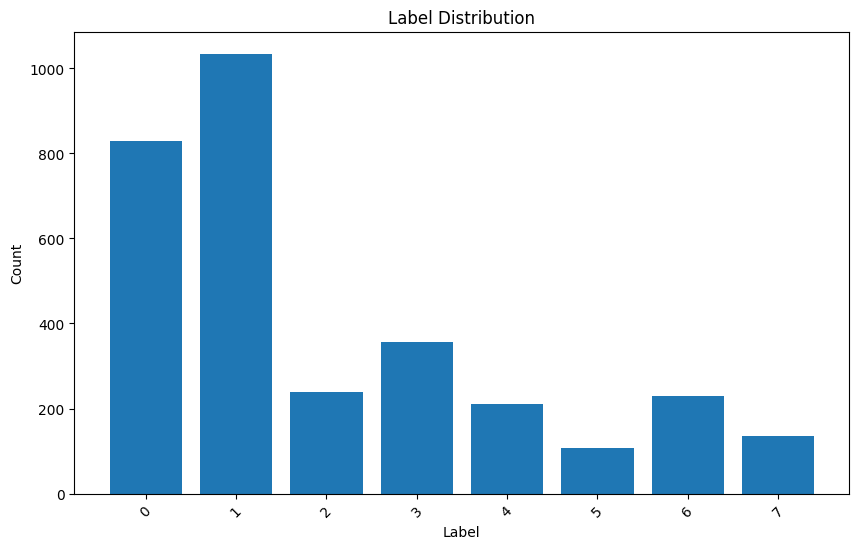

0: 829
2: 238
1: 1035
5: 106
3: 357
7: 136
4: 210
6: 230


100%|██████████████████████████████████████████████████████████████████████████████| 1879/1879 [04:59<00:00,  6.27it/s]


Epochs: 1
               Train Loss:  0.213
               Train Accuracy:  0.869
               Val Loss:  0.217
               Val Accuracy:  0.872


100%|██████████████████████████████████████████████████████████████████████████████| 1879/1879 [05:15<00:00,  5.96it/s]


Epochs: 2
               Train Loss:  0.118
               Train Accuracy:  0.923
               Val Loss:  0.216
               Val Accuracy:  0.885


100%|██████████████████████████████████████████████████████████████████████████████| 1879/1879 [05:15<00:00,  5.95it/s]


Epochs: 3
               Train Loss:  0.086
               Train Accuracy:  0.936
               Val Loss:  0.215
               Val Accuracy:  0.881


100%|██████████████████████████████████████████████████████████████████████████████| 1879/1879 [05:17<00:00,  5.91it/s]


Epochs: 4
               Train Loss:  0.069
               Train Accuracy:  0.943
               Val Loss:  0.214
               Val Accuracy:  0.894


100%|██████████████████████████████████████████████████████████████████████████████| 1879/1879 [05:28<00:00,  5.73it/s]


Epochs: 5
               Train Loss:  0.060
               Train Accuracy:  0.945
               Val Loss:  0.216
               Val Accuracy:  0.902
Test Accuracy:  0.840
Recall for label 0: 76.12%
Precision for label 0: 80.95%
F1 for label 0: 78.46
Recall for label 1: 87.64%
Precision for label 1: 80.83%
F1 for label 1: 84.10
Recall for label 2: 76.92%
Precision for label 2: 80.00%
F1 for label 2: 78.43
Recall for label 3: 93.88%
Precision for label 3: 88.46%
F1 for label 3: 91.09
Recall for label 4: 96.00%
Precision for label 4: 96.00%
F1 for label 4: 96.00
Recall for label 5: 81.82%
Precision for label 5: 81.82%
F1 for label 5: 81.82
Recall for label 6: 96.43%
Precision for label 6: 100.00%
F1 for label 6: 98.18
Recall for label 7: 57.89%
Precision for label 7: 100.00%
F1 for label 7: 73.33


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
"""
here is the code for self learning method 
"""

my_labels = {'Usability':0,
          'Functional':1,
          'Maintainability':2,
          'Security':3,
          'Portability':4,
          'Performance':5,
          'Compatibility':6,
          'Reliability':7
          }
df = pd.read_csv('dataset/user_stories_data.csv')
label_data = df['labels'].tolist()
labels_num = [my_labels[label] for label in label_data]
from collections import Counter
label_counts = Counter(labels_num)
labels,counts = zip(*label_counts.items())


plt.figure(figsize=(10, 6))  
plt.bar(labels, counts, tick_label=[label for label in labels])  
plt.xlabel('Label')  
plt.ylabel('Count')  
plt.title('Label Distribution')  
plt.xticks(rotation=45)  

plt.savefig('label_distribution.png', dpi=300, bbox_inches='tight')  
plt.show()
for label, count in label_counts.items():
    print(f"{label}: {count}")


#read the raw data
file_path = 'dataset/raw_user_stories.txt'
with open(file_path,'r') as file:
    row_data_set = [line.strip() for line in file.readlines()]

model.eval()


reverse_labels={
 0: 'Usability',
 1: 'Functional',
 2: 'Maintainability',
 3: 'Security',
 4: 'Portability',
 5: 'Performance',
 6: 'Compatibility',
 7: 'Reliability'
}
labels = {'Usability':0,
          'Functional':1,
          'Maintainability':2,
          'Security':3,
          'Portability':4,
          'Performance':5,
          'Compatibility':6,
          'Reliability':7
          }

"""
use the finetuined model to predict the labels
"""

def predict_label(text,model,tokenizer,threshold):
    model.eval()
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")
    inputs_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(inputs_ids, attention_mask)
    pros,predictions = torch.softmax(outputs, dim=1).max(dim=1)
    if pros.item() >= threshold:
        predictions = reverse_labels[predictions.item()]
        pros = pros.item()
    else:
        predictions ="uncertain"
        pros = pros.item()
    return pros,predictions

pros=[]
predictions=[]
for text in row_data_set:
    pro,prediction = predict_label(text,model,tokenizer,0.5)
    pros.append(pro)
    predictions.append(prediction)


new_data_set = []
new_label_set=[]
for i in range(len(predictions)):
    if predictions[i] != "uncertain":
        new_data_set.append(row_data_set[i])
        new_label_set.append(predictions[i])
        
df2 = pd.DataFrame({
    'texts': new_data_set,
    'labels': new_label_set
})        

df2.to_csv('new_user_stories.csv',index=False)

# combine the original data and the generate-label-data
df = pd.concat([df,df2],ignore_index=True)
df.to_csv('combined_data.csv', index=False)

np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),[int(.8*len(df)), int(.9*len(df))])
EPOCHS = 5
LR = 1e-5
train_loss=[]
val_loss=[]
train_acc=[]
val_acc=[]
train(model, df_train, df_val, LR, EPOCHS)
evaluate(model, df_test)
